In [1]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
mongo = client.hai

In [2]:
import time

start_time = 1513487106-3600*24*14#1513487106#int(time.time())
end_time = 1513487106-3600*24*1#1513487106+3600+60*9#int(time.time())
username = "sean"
print(start_time, end_time)

1512277506 1513400706


In [3]:
query = {"user_name": username, "pose":{"$exists": True}, "detections":{"$exists": True}, "time": {"$gt": start_time, "$lt": time.time()}}
cams = mongo.images.find(query).distinct("cam_id")
print(cams)
cams = ['webcam0']

['ipcam0', 'webcam0', 'nakacam0', 'nakacam1']


In [4]:
import os
import sys

sys.path.append("..")
os.chdir("/home/sean/HAI/main_server/hai")

In [5]:
%load_ext autoreload
%autoreload 2
from controllers.dbreader.imagereader import ImageReader

In [6]:
imreader = ImageReader()
imdata = imreader.read_db(username, start_time, end_time, cams)

In [7]:
len(imdata)

135977

In [8]:
from controllers.vectorizer.person2vec import Person2Vec
data2vec = Person2Vec()
pose_mat, act_mat, meta = data2vec.vectorize(imdata, get_meta=True)

In [9]:
print(pose_mat.shape, act_mat.shape)

(135977, 54) (135977, 1024)


In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import numpy as np

%matplotlib inline

def plot(x):
    pca = PCA(n_components=2)
    #tsne = TSNE(n_components=2)
    pipe = Pipeline([("std", StandardScaler()), ("pca", pca)])
    x = pipe.fit_transform(x)
    #for t in range(start_time, end_time, 3600):
    #cond = np.where(np.logical_and(time_data2>t, time_data2<=t+3600))
    #plt.scatter(x[cond,0],x[cond,1], label=t)
    plt.scatter(x[:,0], x[:, 1])
    plt.show()
    return x, pipe
    
mask = np.random.choice(len(act_mat), 1000)
mask.sort()

start_time = time.time()
com_X_raw = np.concatenate([act_mat, pose_mat], axis=1)
mask = np.intersect1d(mask, np.where(np.sum(com_X_raw == 0, axis=1) < 54))
com_X = com_X_raw[mask, :]

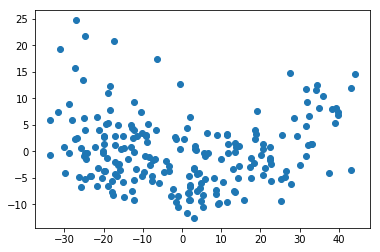

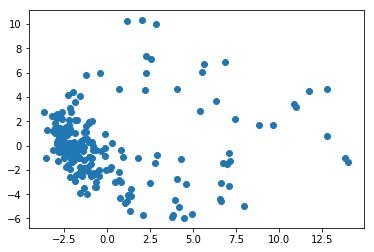

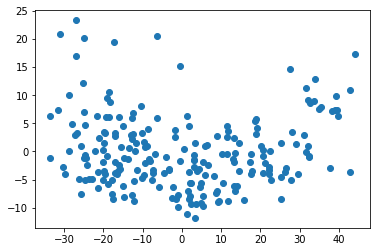

time taken 2.9941318035125732


In [21]:
com_X, com_pipe = plot(com_X)
pose_X, pose_pipe = plot(pose_mat[mask])
act_X, act_pipe = plot(act_mat[mask])
print("time taken", time.time() - start_time)

<IPython.core.display.Javascript object>


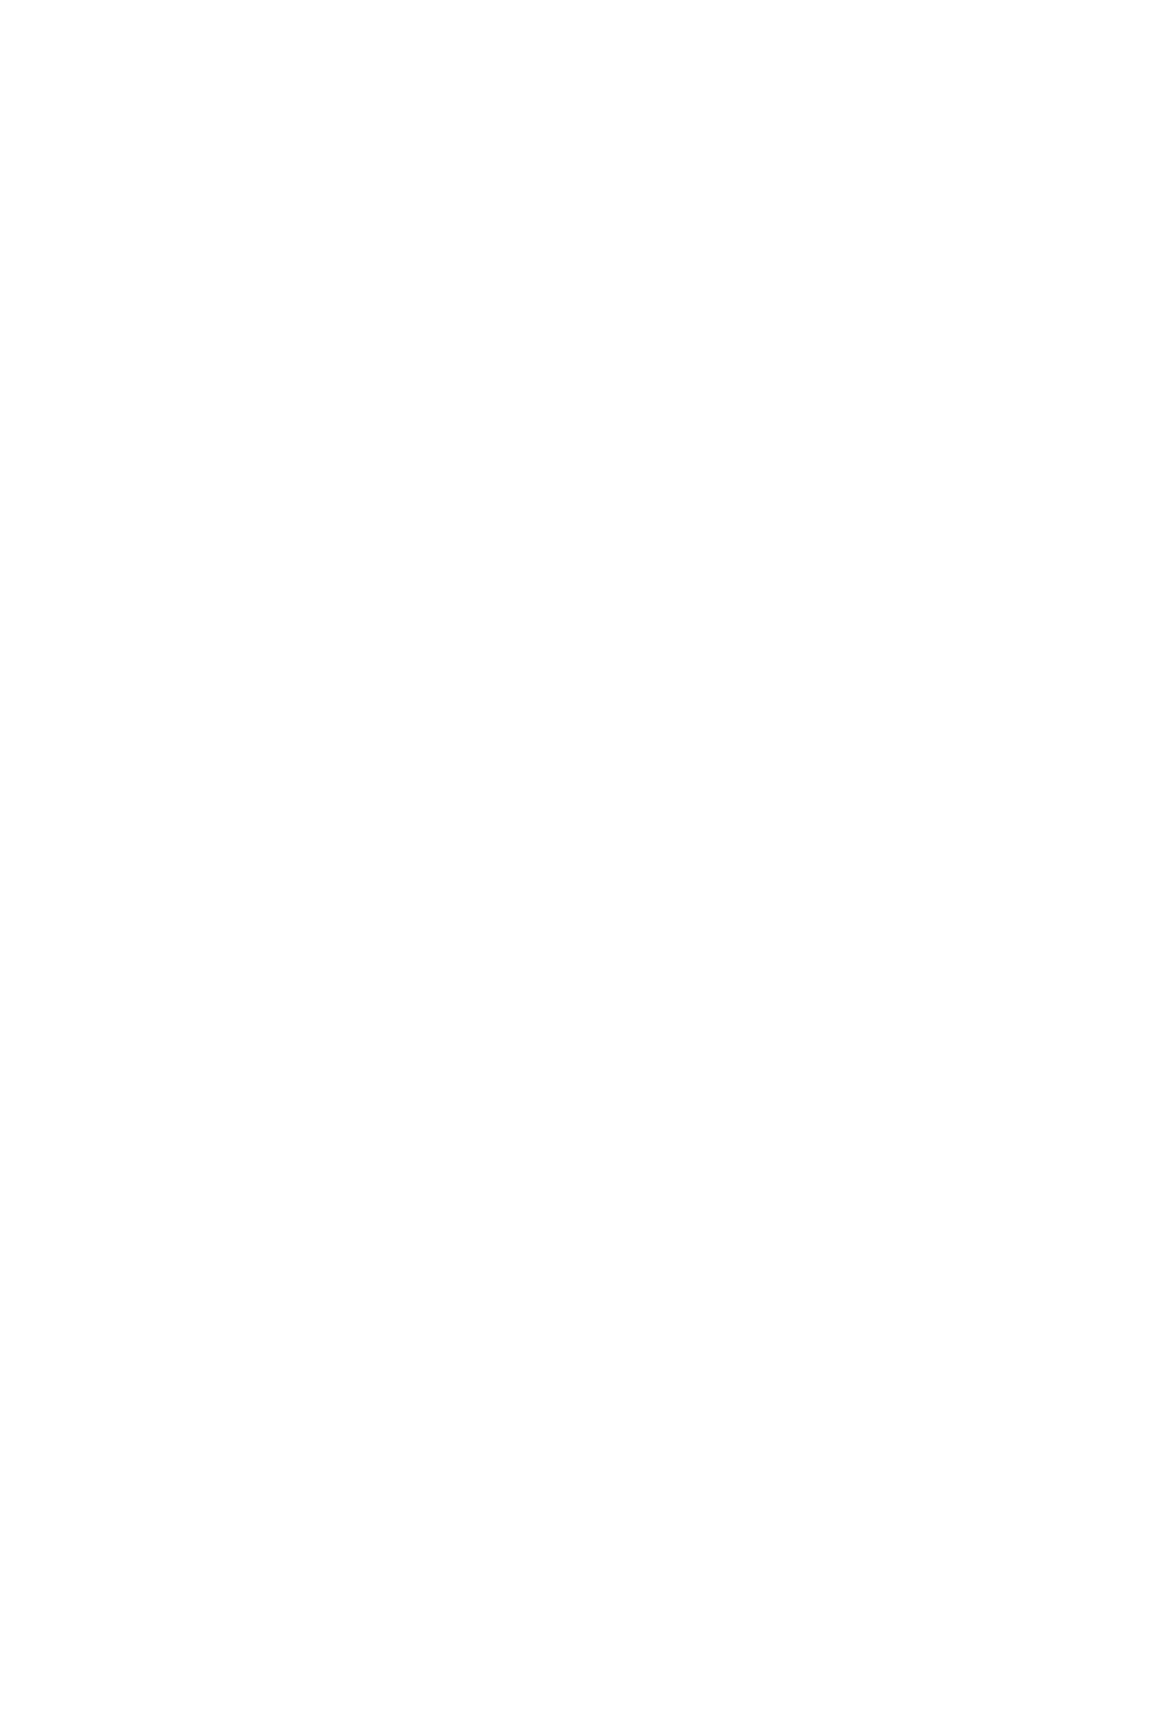

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


<IPython.core.display.Javascript object>


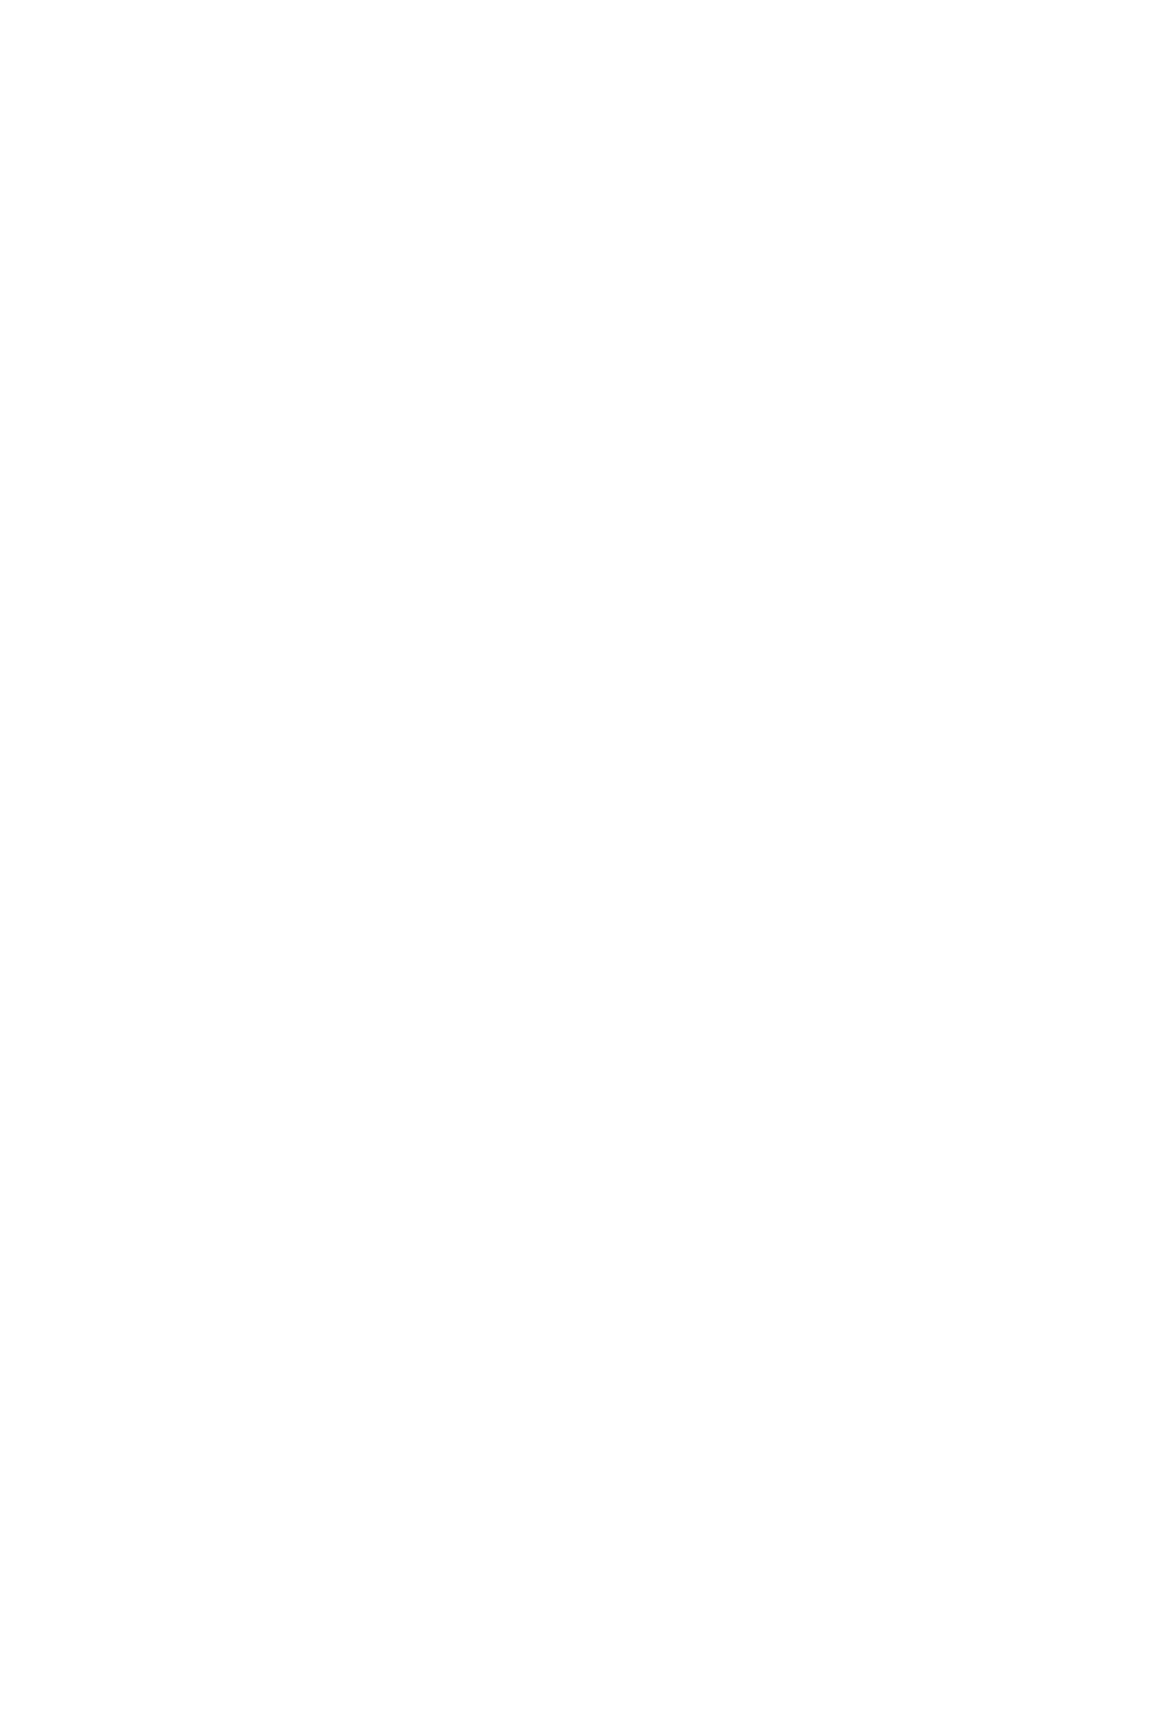

Traceback (most recent call last):
  File "/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 389, in process
    proxy(*args, **kwargs)
  File "/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [22]:
from notebooks.utils.utils import ImageUpdater
import matplotlib.animation as animation

%matplotlib nbagg

"""
labels = []
for i in range(len(imdata)):
    if i < 20:
        labels.append("pc")
    elif i < 34:
        #labels.append("gone")
        labels.append("etc")
    elif i < 93:
        #labels.append("eating")
        labels.append("etc")
    elif i < 104:
        labels.append("pc")
    elif i < 177:
        labels.append("study")
    elif i < 208:
        #labels.append("bed")
        labels.append("etc")
    elif i < 228:
        #labels.append("gone")
        labels.append("etc")
    elif i < 250:
        #labels.append("idle")
        labels.append("etc")
    elif i < 307:
        labels.append("pc")
    elif i < 352:
        labels.append("study")
    elif i <= 435:
        labels.append("etc")
    elif i > 435 and i < 461:
        labels.append("study")
    elif i < 474:
        labels.append("pc")
    elif i < 500:
        labels.append("study")
    else:
        labels.append("etc")
"""

#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#labels = le.fit_transform(labels)

fig, axes = plt.subplots(4, len(cams), figsize=(8,12), squeeze=False)
updater = ImageUpdater(axes, np.array(imdata)[mask], pose_X, act_X, com_X, np.array(meta)[mask], None)
ani = animation.FuncAnimation(fig, updater, frames=range(len(com_X)), interval=100, repeat=False)
ani.save('test.mp4', writer="ffmpeg")